In [60]:
from torchsr.datasets import Div2K
from torchsr.models import ninasr_b0
from torchvision.transforms.functional import to_pil_image, to_tensor
from torch.utils.data import Dataset
from torch import nn
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Div2K dataset
dataset = Div2K(root="./data", scale=2, download=False)

In [61]:
hr, lr = dataset[0]

In [74]:
class ImageDataset(Dataset):
    def __init__(self, coordinates, pixel_values):
        self.coordinates = coordinates.astype(np.float32)
        self.pixel_values = pixel_values.astype(np.float32)
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.coordinates[idx]
        pixel = self.pixel_values[idx]
        return coord, pixel
    
class INRModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=4, dropout_rate=0.5):
        super().__init__()
        
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range since the rgb values are normalized
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def train_model(self, dataloader, num_epochs = 100, lr = 1e-3, device = 'cpu' if not torch.cuda.is_available() else 'cuda', criterion = nn.MSELoss(), optimizer = None):
        if optimizer is None:
            optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.train()
        self.to(device)
        
        losses = []
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass
                pred_pixels = self(batch_coords)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        
        return losses
    
class Sine(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        
    def forward(self, x):
        return torch.sin(self.omega_0 * x)
    
class BabySINE(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=4, omega_0=30, sigma=10.0, dropout_rate=0.5):
        super().__init__()
        self.sigma_0 = sigma
        self.omega_0 = omega_0
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(Sine(omega_0))
        #layers.append(nn.SiLU())
        #layers.append(nn.BatchNorm1d(hidden_dim))
        #layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(Sine())
            #layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range since the rgb values are normalized
        
        self.network = nn.Sequential(*layers)

        self._initialize_weights()
        """
    def _initialize_weights(self):
        Initialize weights using a uniform distribution scaled by 1/sqrt(hidden_dim).
        with torch.no_grad():
            for layer in self.network:
                if isinstance(layer, nn.Linear):
                    nn.init.uniform_(layer.weight, -1 / torch.sqrt(torch.tensor(layer.in_features)), 
                                    1 / torch.sqrt(torch.tensor(layer.in_features)))
                    nn.init.zeros_(layer.bias)"""
    def _initialize_weights(self):
        """SIREN-style weight initialization"""
        with torch.no_grad():
            for idx, layer in enumerate(self.network):
                if isinstance(layer, nn.Linear):
                    # Calculate fan_in
                    fan_in = layer.weight.size(1)
                    
                    # First layer initialization
                    if idx == 0:  # First linear layer
                        bound = 1 / fan_in
                    else:
                        bound = torch.sqrt(torch.tensor(6.0 / fan_in)) / self.omega_0
                        
                    # Uniform initialization
                    nn.init.uniform_(layer.weight, -bound, bound)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        """Forward pass with optional sigma scaling"""
        if sigma is None:
            sigma = self.sigma
        # Scale input coordinates by sigma
        x = x * sigma
        return self.network(x)
    
    def train_model(self, dataloader, num_epochs = 100, lr = 1e-3, device = 'cpu' if not torch.cuda.is_available() else 'cuda', criterion = nn.MSELoss(), optimizer = None, sigma=10.0, sigma_decay=None):
        if optimizer is None:
            optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.train()
        self.to(device)
        current_sigma = sigma
        losses = []
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            if sigma_decay:
                current_sigma *= sigma_decay
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass
                pred_pixels = self(batch_coords, current_sigma)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        
        return losses

In [75]:
def plot_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original Image: {title}")
    plt.show()

    # Get image dimensions
    height_target, width_target, channels = image.shape
    print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")


def pixel_coordinates_normalized(image, downsize_factor): 
    print(image.shape[0])
    x, y = image.shape[:2]
    resized_image = cv.resize(image, (y // downsize_factor, x // downsize_factor))
    resized_x, resized_y = resized_image.shape[:2]
    xs = np.linspace(0, 1, resized_x)  # x coordinates (0 to 1)
    ys = np.linspace(0, 1, resized_y)  # y coordinates (0 to 1)

    xx, yy = np.meshgrid(xs, ys, indexing="ij")
    coordinates = np.stack((xx, yy), axis=-1)
    coordinates = coordinates.reshape(-1, 2) 
    resized_image = resized_image/255.0
    norm_resized_image = (resized_image - np.mean(resized_image)) / np.std(resized_image)
    pixel_values = norm_resized_image.reshape(-1, 3)
    
    return coordinates, pixel_values, norm_resized_image, resized_x, resized_y



In [76]:
image = np.array(hr)

#plot_image(image)
coordinates, pixel_values, norm_image, x, y = pixel_coordinates_normalized(image, 10)
downsize_factor = 3
print(f"Downsize factor: {downsize_factor}")

1404
Downsize factor: 3


In [77]:
# Create dataset and dataloader
dataset = ImageDataset(coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)


In [78]:
# # Create and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
channels = 3

# model = INRModel(input_dim=2, output_dim=channels, hidden_dim=128, num_layers=3, dropout_rate=0.5)


# # Plot the loss curve
# plt.figure(figsize=(10, 4))
# plt.plot(losses)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

In [ ]:
# Initialize model with DEFAULT parameters (sigma=10.0 built into model)
model = BabySINE(sigma=10.0, omega_0=15)  # sigma here sets DEFAULT value, can be overridden in training

# Single training process with progressive sigma scaling
losses = model.train_model(
    dataloader,
    num_epochs=300,  # Total epochs (100 + 200)
    lr=1e-4,
    sigma=5.0,  # Starting sigmas   
)

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]


TypeError: forward() takes 2 positional arguments but 3 were given

Max and Min values of pred_pixels: 0.5692476034164429, 0.4400870203971863


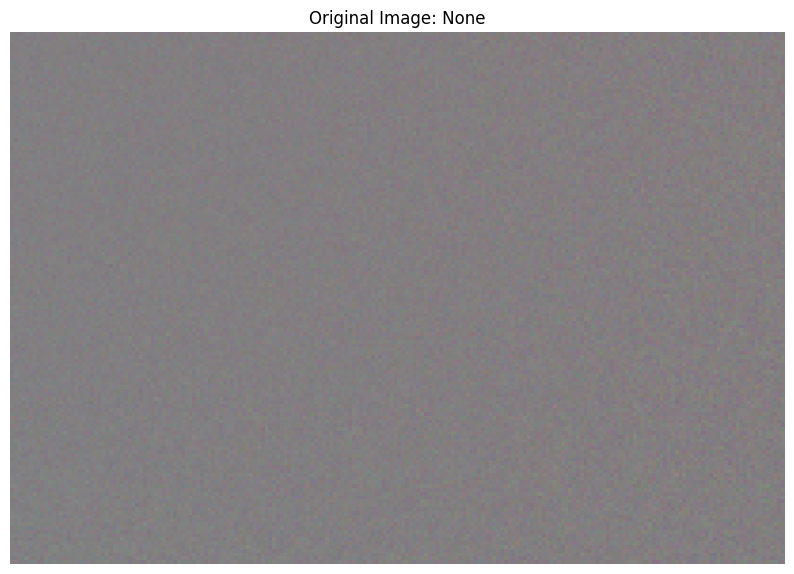

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimensions: 140x204, 3 channels


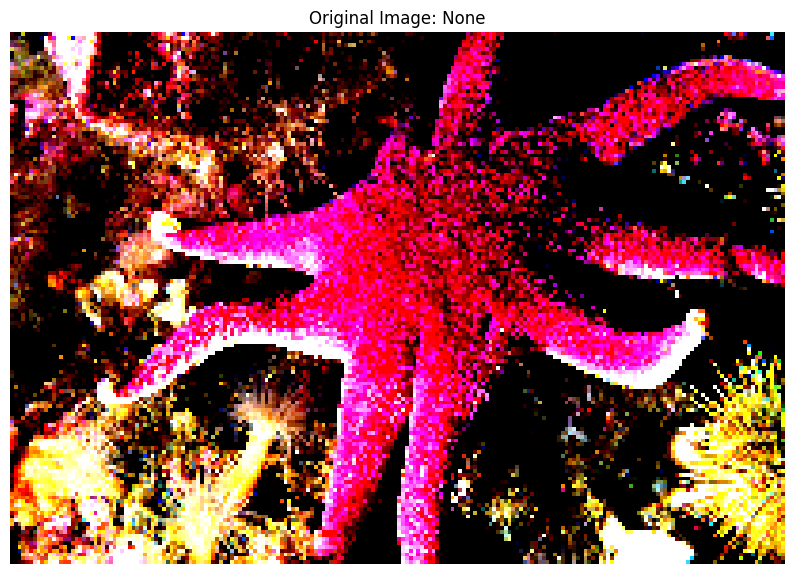

Image dimensions: 140x204, 3 channels
Downsized image shape: (140, 204, 3)
Reconstructed image shape: (140, 204, 3)
Original image shape: (140, 204, 3)


In [ ]:
target_coords_tensor = torch.from_numpy(coordinates).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

reconstructed_img_reshaped_normalized = pred_pixels.reshape(x, y, channels)
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)
plot_image(reconstructed_img_reshaped_denormalized)
plot_image(norm_image)
# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {norm_image.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {norm_image.shape}")

In [ ]:
target_coords_tensor = torch.from_numpy(coordinates).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

reconstructed_img_reshaped_normalized = pred_pixels.reshape(x, y, channels)
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)
plot_image(reconstructed_img_reshaped_denormalized)
plot_image(norm_image)
# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {norm_image.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {norm_image.shape}")